In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import glob
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score, denoise
from src.sampling_utils import random_step, langevin_step, repulsive_step
from src.kernel import RBF

import torch
import torch.nn as nn
import torch.nn.functional as F
# import autograd.numpy as anp

/data/ap2619/diffusion/score_sde_pytorch/.venv_score/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-28 00:54:12.622661: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: module 'triton.language' has no attribute 'constexpr'


In [2]:
# Using 512x512 resolution
model_id = "stabilityai/stable-diffusion-2-base"
# model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id)#, torch_dtype=torch.float16)
device = "cuda"
pipe = pipe.to(device)
pipe.safety_checker = None

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 7966.97it/s]
/data/ap2619/diffusion/score_sde_pytorch/.venv_score/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# Settings
prompt = ["a black cat"]
config = {
    "pipe": pipe,
    "height": 512,
    "width": 512,
    "num_inference_steps": 20,
    "num_train_timesteps": 1000,
    "batch_size": 1,
    "cfg": 8,
    "beta_start": 0.00085,
    "beta_end": 0.012,
}

# Seeds
seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(0)
random.seed(0)

# Noise levels
sigmas, timesteps = get_sigmas(config, device=device)
init_latents, text_embeddings = get_score_input(prompt, config, generator=generator, device="cuda")
config = {**config,
          "sigmas": sigmas,
          "timesteps": timesteps,
          "init_latents": init_latents,
          "text_embeddings": text_embeddings
          }

In [6]:
latent = denoise([1], 0, config, return_all_samples=False, generator=generator)

100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


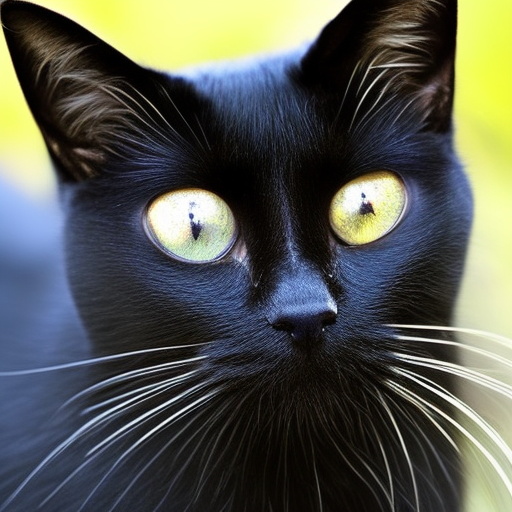

In [5]:
# Plot image results
image = output_to_img(decode_latent(latent, config['pipe'].vae))
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Particles

In [4]:
# CNN model
class CNN(nn.Module):
    # Resnet50 inspired
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=0)
        self.act = nn.ReLU()

    def forward(self, x):
        # input is 1x4x64x64
        x = self.conv1(x) # 1x8x32x32
        x = self.act(x)
        x = self.conv2(x) # 1x8x16x16
        x = self.act(x)
        x = self.conv3(x) # 1x16x8x8
        x = self.act(x)
        x = self.conv4(x) # 1x16x4x4
        x = self.act(x)
        x = self.conv5(x) # 1x32x2x2
        x = self.act(x)
        x = self.conv6(x) # 1x64x1x1
        return x.squeeze()

def init_weights(m):
    # Kaiming initialisation used in "A Random CNN Sees Objects" paper
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

path = "model.pt"
net = CNN()

# Initialise weights
# net.apply(init_weights)
# Store weights and model
# torch.save(net.state_dict(), path)

# Load model instead of re-initialising
net.load_state_dict(torch.load(path))
net.to(torch.device("cuda"))

CNN(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (act): ReLU()
)

In [7]:
K = RBF()
phi = net(latent).unsqueeze(0)
K.sigma = 1
kernel_grad = K.grad_first(phi,phi+1)

In [9]:
latent.requires_grad=True
grad = torch.autograd.functional.jacobian(net, latent)


In [22]:
torch.einsum('i,ijklm->jklm',kernel_grad.squeeze(), grad)

tensor([[[[ 2.0459e-32, -2.2827e-32,  3.5016e-32,  ..., -5.9761e-32,
           -1.3356e-33,  3.2551e-32],
          [ 2.5570e-32, -4.4135e-34, -6.3286e-32,  ..., -2.7532e-32,
           -1.0942e-31, -3.8368e-32],
          [-2.1688e-32,  1.5524e-32,  2.2222e-32,  ...,  1.2925e-31,
           -3.7139e-32,  1.2803e-33],
          ...,
          [-2.8696e-32,  2.5501e-32, -2.3965e-32,  ..., -2.1567e-33,
            3.3135e-33, -1.0161e-32],
          [ 8.7118e-33, -1.4827e-32,  7.2947e-33,  ..., -5.0797e-34,
           -7.1073e-33,  1.9392e-33],
          [-1.1193e-32,  2.0489e-32,  8.6525e-33,  ...,  5.9680e-33,
            4.9564e-33, -2.1460e-33]],

         [[ 3.0591e-32,  9.3807e-32, -1.1578e-32,  ...,  2.0707e-32,
            4.1780e-32, -2.6366e-33],
          [ 2.2629e-32,  5.4140e-32, -9.6985e-32,  ..., -2.4862e-33,
           -1.2618e-31,  1.1901e-31],
          [-2.2153e-32, -5.7608e-32, -8.2661e-32,  ..., -1.0749e-31,
           -6.9873e-32,  1.5039e-31],
          ...,
     

In [41]:
def repulsive_step(
        particles,
        scores,
        model,
        K,
        generator,
        add_noise = False,
        step_size=0.2,
        repulsive_scale=1.0, # strength of repulsive term
        device="cuda",
    ):
        """ TODO Take repulsive langevin step. 
            particles: list of latent samples
            score: list of scores for each latent sample
            model: embedding model for latents to smaller dim space
            K: Kernel function
        
        """
        phis = []
        grads = []
        for particle in particles:
            # Embed latent to smaller dimension
            phi = model(particle)
            phis.append(phi.unsqueeze(0))

            # Compute gradient ∇_latent (phi) for pushforward gradient computation
            grad = torch.autograd.functional.jacobian(
                model, 
                particle.clone().detach().requires_grad_()
            )
            grads.append(grad)

        # Repulsive term: Compute kernel gradient
        n = len(particles)
        new_particles = []
        for i, phi in enumerate(phis):
            repulsive = 0
            for j in range(i,len(phis)):
                # TODO: Compute kernel gradient on phi matrix rather than one by one to get it working
                # Can do bandwidth calculation just at beginning?
                # K.bandwidth(phi, phis[j])
                K.sigma = torch.tensor(1, device="cuda")
                kernel_grad = K.grad_first(phi,phis[j])
                repulsive += kernel_grad.squeeze()
            
            # Pushforward/Chain rule
            # TODO: Check this multiplication is right
            repulsive = torch.einsum('i,ijklm->jklm',repulsive, grads[i]) / n

            # Langevin term
            noise = torch.randn(particles[i].shape, layout=particles[i].layout, device=device, generator=generator).to(device)

            new_particle = particles[i] + step_size * (scores[i] + repulsive_scale * repulsive)
            if add_noise:
                new_particle += ((step_size * 2) ** 0.5) * noise

            new_particles.append(new_particle)
        return new_particles

In [42]:
# Particle diffusion
def correct_particles(
    particles,
    sigma,
    t,
    correction_steps,
    correct_type,
    config,
    model=None,
    K=None,
    ):
    """ At certain noise scale (step t), apply correction steps
        particles: N particles in the diffusion process
        correct_type (str): type of correction step "random", "langevin" or "repulsive"
        model: Embedding model (must be defined if repulsive correct_type specified)
        K: RBF Kernel (must be defined if repulsive correct_type specified)
        TODO: Make sampler factory class
    """
    if correct_type=="repulsive":
        for _ in range(correction_steps):
            scores = [get_score(particle, sigma, t, config) for particle in particles]
            particles = repulsive_step(particles, scores, model, K, generator)
        new_particles = particles
    else:
        new_particles = []
        for particle in particles:
            for _ in range(correction_steps):
                score = get_score(particle, sigma, t, config)
                if correct_type=="random":
                    particle = random_step(particle, score, generator)
                elif correct_type=="langevin":
                    particle = langevin_step(particle, score, generator)
                else:
                    print(f"ERROR: Correction step type: '{correct_type}' not implemented yet")
            new_particles.append(particle)
    return new_particles

def denoise_particles(
    correction_levels,
    correction_steps,
    config,
    num_particles=2,
    device="cuda",
):
    # standard deviation of the initial noise distribution
    sigmas = config['sigmas']
    latents = config['init_latents'] * sigmas.max()

    # Embedding model for repulsive force
    model = CNN()
    model.load_state_dict(torch.load(path))
    model.to(torch.device("cuda"))

    # RBF Kernel
    K = RBF()

    particles = [latents]
    for i, t in enumerate(tqdm(config['timesteps'])):
        t = t.to(device)
        step_index = (config['timesteps'] == t).nonzero().item()
        sigma = sigmas[step_index]

        # Create particles
        if i==0:
            # Create initial set of particles by taking langevin steps
            for _ in range(num_particles-1):
                new_particle = correct_particles([particles[-1]], sigma, t, correction_steps=1, correct_type="langevin", config=config)
                particles.append(new_particle[0])
        
        # Correction steps
        if i in correction_levels:
            particles = correct_particles(particles, sigma, t, correction_steps, correct_type="repulsive", config=config, model=model, K=K)
        
        # Move to next marginal in diffusion
        for n in range(len(particles)):
            score = get_score(particles[n], sigma, t, config)
            particles[n] = step_score(particles[n], score, sigmas, step_index)
    
    return particles

In [49]:
particles = denoise_particles([0],10,config, num_particles=8)

  0%|          | 0/20 [00:00<?, ?it/s]

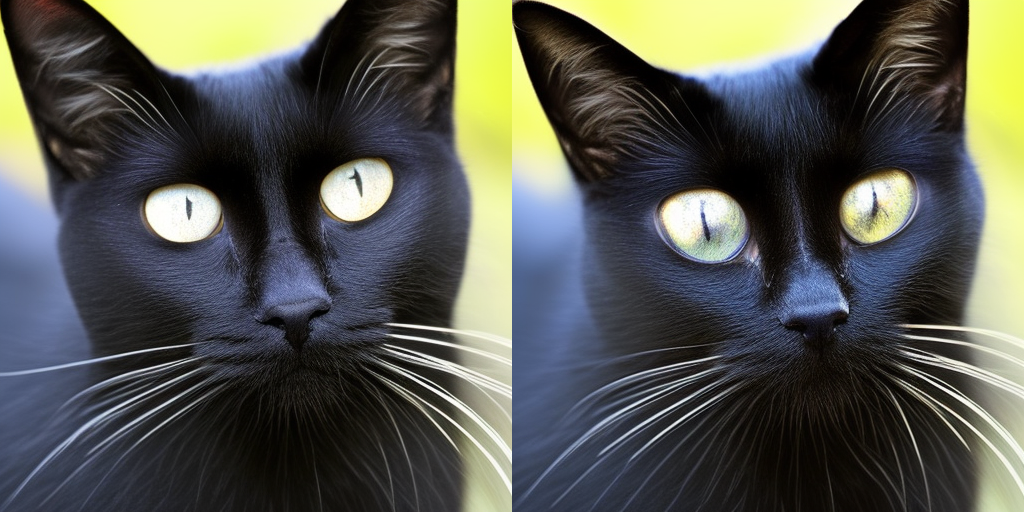

In [48]:
# Plot image results
# Plot list of decoded latents
visualise_latent_list = particles

pil_images = []
for l in visualise_latent_list:
    image = output_to_img(decode_latent(l, pipe.vae))
    images = (image * 255).round().astype("uint8")
    pil_images.append([Image.fromarray(image) for image in images][0])

image_grid(pil_images,1,len(visualise_latent_list))